In [4]:
import cv2
import os
from tqdm import tqdm 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [5]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# Loading the training data

In [6]:
data_dir = r'C:\Users\ismaeeel\Downloads\archive\train'
train_df = loading_the_data(data_dir)

train_df

,filepaths,labels
0,C:\Users\ismaeeel\Downloads\archive\train\beni...,benign
1,C:\Users\ismaeeel\Downloads\archive\train\beni...,benign
2,C:\Users\ismaeeel\Downloads\archive\train\beni...,benign
3,C:\Users\ismaeeel\Downloads\archive\train\beni...,benign
4,C:\Users\ismaeeel\Downloads\archive\train\beni...,benign
...,...,...
2632,C:\Users\ismaeeel\Downloads\archive\train\mali...,malignant
2633,C:\Users\ismaeeel\Downloads\archive\train\mali...,malignant
2634,C:\Users\ismaeeel\Downloads\archive\train\mali...,malignant
2635,C:\Users\ismaeeel\Downloads\archive\train\mali...,malignant


# Loading the testing data

In [7]:

data_dir = r'C:\Users\ismaeeel\Downloads\archive\test'
ts_df = loading_the_data(data_dir)

ts_df

,filepaths,labels
0,C:\Users\ismaeeel\Downloads\archive\test\benig...,benign
1,C:\Users\ismaeeel\Downloads\archive\test\benig...,benign
2,C:\Users\ismaeeel\Downloads\archive\test\benig...,benign
3,C:\Users\ismaeeel\Downloads\archive\test\benig...,benign
4,C:\Users\ismaeeel\Downloads\archive\test\benig...,benign
...,...,...
655,C:\Users\ismaeeel\Downloads\archive\test\malig...,malignant
656,C:\Users\ismaeeel\Downloads\archive\test\malig...,malignant
657,C:\Users\ismaeeel\Downloads\archive\test\malig...,malignant
658,C:\Users\ismaeeel\Downloads\archive\test\malig...,malignant


# Data Preprocessing

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen():
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        rotation_range=15,  # Random rotations
        horizontal_flip=True,  # Random horizontal flips
        zoom_range=0.1  # Random zoom
    )

    # For testing, only rescaling is needed
    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def load_data_with_generator(train_dir, test_dir, img_size=64, batch_size=32):
    train_datagen, test_datagen = create_datagen()

    # Create a training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    # Create a testing data generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    return train_generator, test_generator

# Define your directories
train_dir = r'C:\Users\ismaeeel\Downloads\archive\train'
test_dir = r'C:\Users\ismaeeel\Downloads\archive\test'

train_generator, test_generator = load_data_with_generator(train_dir, test_dir)



Found 2637 images belonging to 2 classes.


Found 660 images belonging to 2 classes.


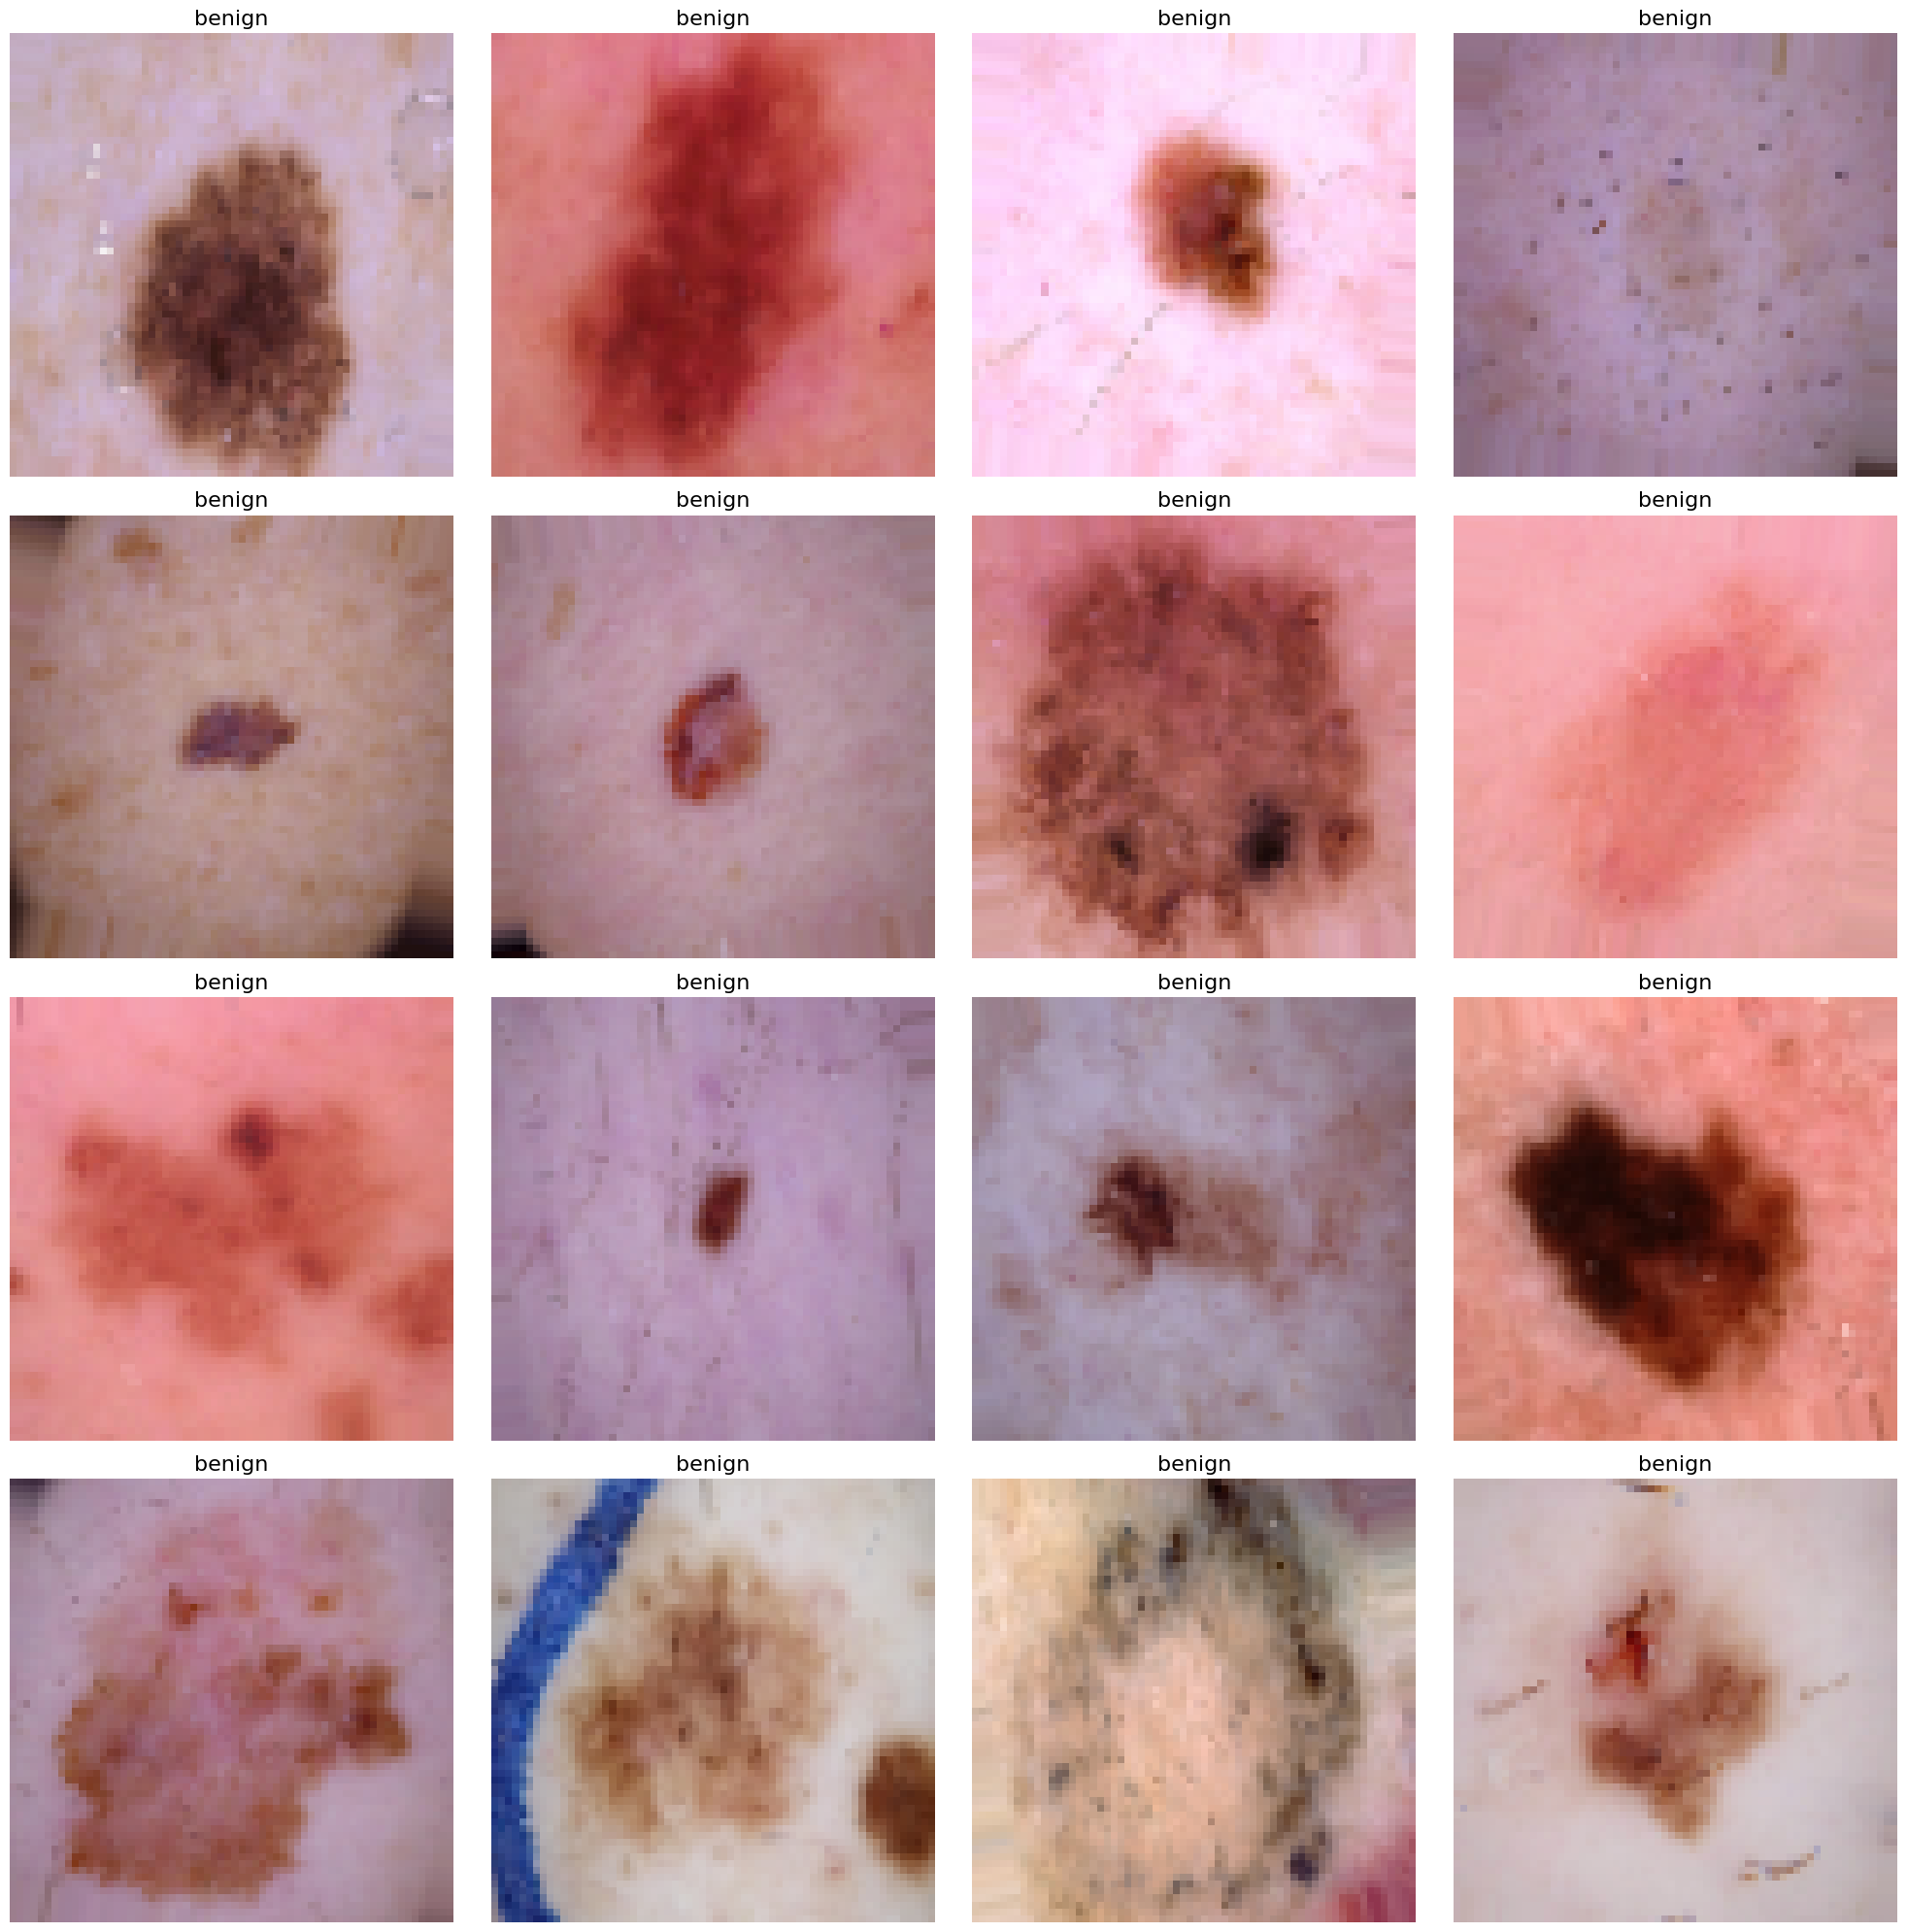

In [9]:
def display_sample_images(generator):
    """
    Display a batch of images from a data generator.
    """
    images, labels = next(generator)  
    classes = list(generator.class_indices.keys())  
    
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i]) 
        class_name = classes[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
        if i == 15:  
            break
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator)


# Build Custom CNN

In [10]:
def build_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])
    return model

custom_cnn_model = build_custom_cnn((64, 64, 3), 1)

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [11]:
history_custom_cnn = custom_cnn_model.fit(
    train_generator, 
    validation_data=test_generator, 
    epochs=10,  
    batch_size=32)  

Epoch 1/10
83/83 [==============================] - 32s 364ms/step - loss: 0.5851 - accuracy: 0.6765 - val_loss: 0.5208 - val_accuracy: 0.6985
Epoch 2/10
83/83 [==============================] - 10s 124ms/step - loss: 0.5173 - accuracy: 0.7509 - val_loss: 0.4448 - val_accuracy: 0.7606
Epoch 3/10
83/83 [==============================] - 10s 122ms/step - loss: 0.4494 - accuracy: 0.7789 - val_loss: 0.4082 - val_accuracy: 0.8182
Epoch 4/10
83/83 [==============================] - 10s 126ms/step - loss: 0.4976 - accuracy: 0.7611 - val_loss: 0.4181 - val_accuracy: 0.7758
Epoch 5/10
83/83 [==============================] - 9s 113ms/step - loss: 0.4165 - accuracy: 0.8055 - val_loss: 0.4848 - val_accuracy: 0.7197
Epoch 6/10
83/83 [==============================] - 10s 124ms/step - loss: 0.4223 - accuracy: 0.7929 - val_loss: 0.4378 - val_accuracy: 0.7515
Epoch 7/10
83/83 [==============================] - 10s 120ms/step - loss: 0.4019 - accuracy: 0.8108 - val_loss: 0.3705 - val_accuracy: 0.8197


In [12]:
test_loss, test_acc = custom_cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 [==============================] - 1s 41ms/step - loss: 0.3725 - accuracy: 0.8121
Test accuracy: 0.8121212124824524, Test loss: 0.37254998087882996


In [13]:
test_generator.reset() 
predictions_custom_cnn = custom_cnn_model.predict(test_generator)
predicted_classes_custom_cnn = (predictions_custom_cnn > 0.5).astype(int)
true_classes = test_generator.classes

print("Custom CNN Model Evaluation")
print(classification_report(true_classes, predicted_classes_custom_cnn))

fpr, tpr, thresholds = roc_curve(true_classes, predictions_custom_cnn)
roc_auc = auc(fpr, tpr)

21/21 [==============================] - 1s 42ms/step
Custom CNN Model Evaluation
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       360
           1       0.46      0.60      0.52       300

    accuracy                           0.50       660
   macro avg       0.51      0.51      0.50       660
weighted avg       0.51      0.50      0.50       660



# VGG16 Model

In [14]:
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg16_model = build_vgg16_model((64, 64, 3), 1)

vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model.summary()


58889256/58889256 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 15764289 (60.14 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [15]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10, 
    batch_size=32  
)

Epoch 1/10
83/83 [==============================] - 27s 319ms/step - loss: 0.5167 - accuracy: 0.7474 - val_loss: 0.4131 - val_accuracy: 0.8288
Epoch 2/10
83/83 [==============================] - 27s 321ms/step - loss: 0.4249 - accuracy: 0.8074 - val_loss: 0.3725 - val_accuracy: 0.8227
Epoch 3/10
83/83 [==============================] - 27s 320ms/step - loss: 0.3988 - accuracy: 0.8146 - val_loss: 0.3790 - val_accuracy: 0.8136
Epoch 4/10
83/83 [==============================] - 26s 314ms/step - loss: 0.3786 - accuracy: 0.8225 - val_loss: 0.3629 - val_accuracy: 0.8258
Epoch 5/10
83/83 [==============================] - 27s 327ms/step - loss: 0.3697 - accuracy: 0.8210 - val_loss: 0.3987 - val_accuracy: 0.8015
Epoch 6/10
83/83 [==============================] - 26s 309ms/step - loss: 0.3571 - accuracy: 0.8316 - val_loss: 0.3461 - val_accuracy: 0.8470
Epoch 7/10
83/83 [==============================] - 26s 310ms/step - loss: 0.3535 - accuracy: 0.8331 - val_loss: 0.3401 - val_accuracy: 0.8318

In [16]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 [==============================] - 5s 230ms/step - loss: 0.3456 - accuracy: 0.8333
Test accuracy: 0.8333333134651184, Test loss: 0.34561213850975037


In [17]:
test_generator.reset()  
predictions_vgg16 = vgg16_model.predict(test_generator)
predicted_classes_vgg16 = (predictions_vgg16 > 0.5).astype(int)

print("VGG16 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg16))

fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(true_classes, predictions_vgg16)
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

21/21 [==============================] - 5s 230ms/step
VGG16 Model Evaluation
              precision    recall  f1-score   support

           0       0.54      0.46      0.50       360
           1       0.45      0.54      0.49       300

    accuracy                           0.49       660
   macro avg       0.50      0.50      0.49       660
weighted avg       0.50      0.49      0.49       660



# Build the VGG19 Model

In [18]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models, layers

def build_vgg19_model(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg19_model = build_vgg19_model((64, 64, 3), 1)

vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 [==============================] - 8s 0us/step


In [19]:
history_vgg19 = vgg19_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
83/83 [==============================] - 32s 367ms/step - loss: 0.5832 - accuracy: 0.7080 - val_loss: 0.4314 - val_accuracy: 0.7985
Epoch 2/10
83/83 [==============================] - 30s 360ms/step - loss: 0.4566 - accuracy: 0.7721 - val_loss: 0.4564 - val_accuracy: 0.8015
Epoch 3/10
83/83 [==============================] - 28s 340ms/step - loss: 0.4264 - accuracy: 0.7952 - val_loss: 0.3751 - val_accuracy: 0.8182
Epoch 4/10
83/83 [==============================] - 29s 353ms/step - loss: 0.4032 - accuracy: 0.8066 - val_loss: 0.3640 - val_accuracy: 0.8273
Epoch 5/10
83/83 [==============================] - 29s 353ms/step - loss: 0.3927 - accuracy: 0.8146 - val_loss: 0.3593 - val_accuracy: 0.8227
Epoch 6/10
83/83 [==============================] - 31s 375ms/step - loss: 0.3759 - accuracy: 0.8244 - val_loss: 0.3488 - val_accuracy: 0.8455
Epoch 7/10
83/83 [==============================] - 30s 362ms/step - loss: 0.3863 - accuracy: 0.8225 - val_loss: 0.3396 - val_accuracy: 0.8500

In [20]:
test_loss, test_acc = vgg19_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 [==============================] - 6s 271ms/step - loss: 0.3652 - accuracy: 0.8152
Test accuracy: 0.8151515126228333, Test loss: 0.3652086555957794


In [21]:
test_generator.reset()  
predictions_vgg19 = vgg19_model.predict(test_generator)
predicted_classes_vgg19 = (predictions_vgg19 > 0.5).astype(int)


21/21 [==============================] - 6s 271ms/step


In [22]:
print("VGG19 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg19))

fpr_vgg19, tpr_vgg19, thresholds_vgg19 = roc_curve(true_classes, predictions_vgg19)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

VGG19 Model Evaluation
              precision    recall  f1-score   support

           0       0.54      0.41      0.47       360
           1       0.45      0.58      0.51       300

    accuracy                           0.49       660
   macro avg       0.50      0.50      0.49       660
weighted avg       0.50      0.49      0.49       660



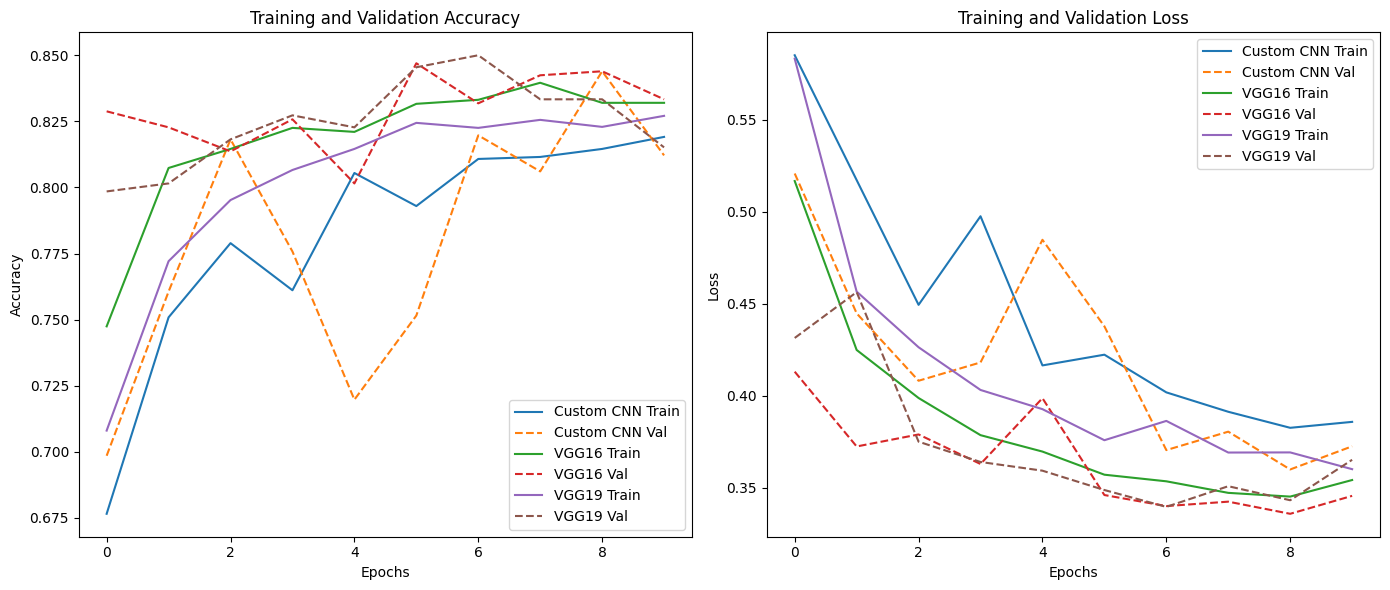

In [23]:
def plot_model_history(model_histories, labels, metric='accuracy'):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history[metric], label=f'{label} Train')
        plt.plot(history.history[f'val_{metric}'], '--', label=f'{label} Val')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train')
        plt.plot(history.history['val_loss'], '--', label=f'{label} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(
    [history_custom_cnn, history_vgg16, history_vgg19],
    ['Custom CNN', 'VGG16', 'VGG19']
)

Custom CNN Model Confusion Matrix


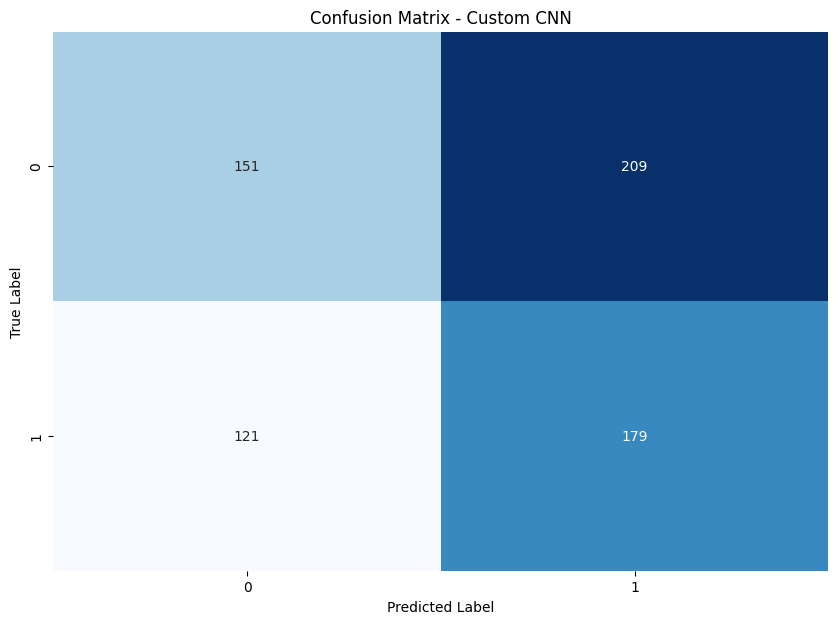

VGG16 Model Confusion Matrix


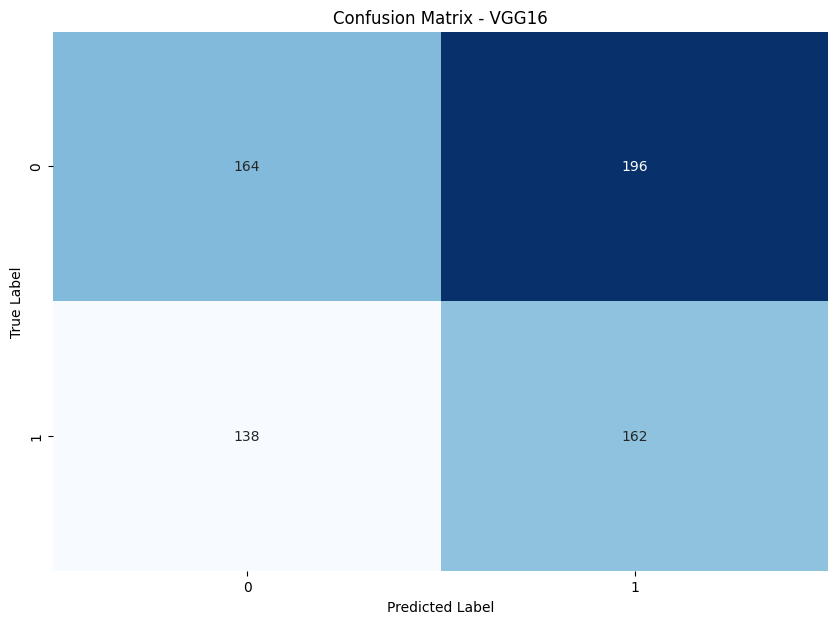

VGG19 Model Confusion Matrix


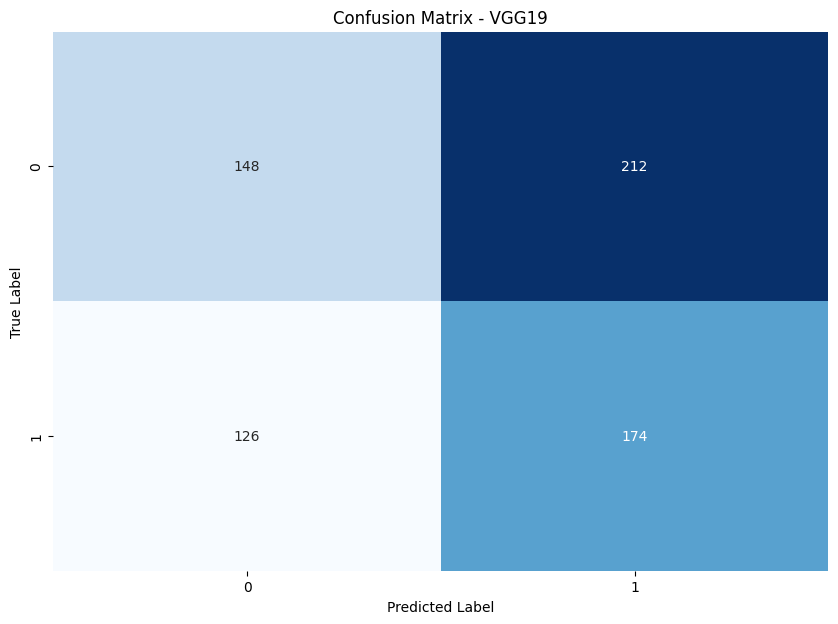

In [24]:
def plot_confusion_matrix(true_classes, predicted_classes, title='Confusion Matrix'):
    matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("Custom CNN Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_custom_cnn, 'Confusion Matrix - Custom CNN')

print("VGG16 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg16, 'Confusion Matrix - VGG16')

print("VGG19 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg19, 'Confusion Matrix - VGG19')


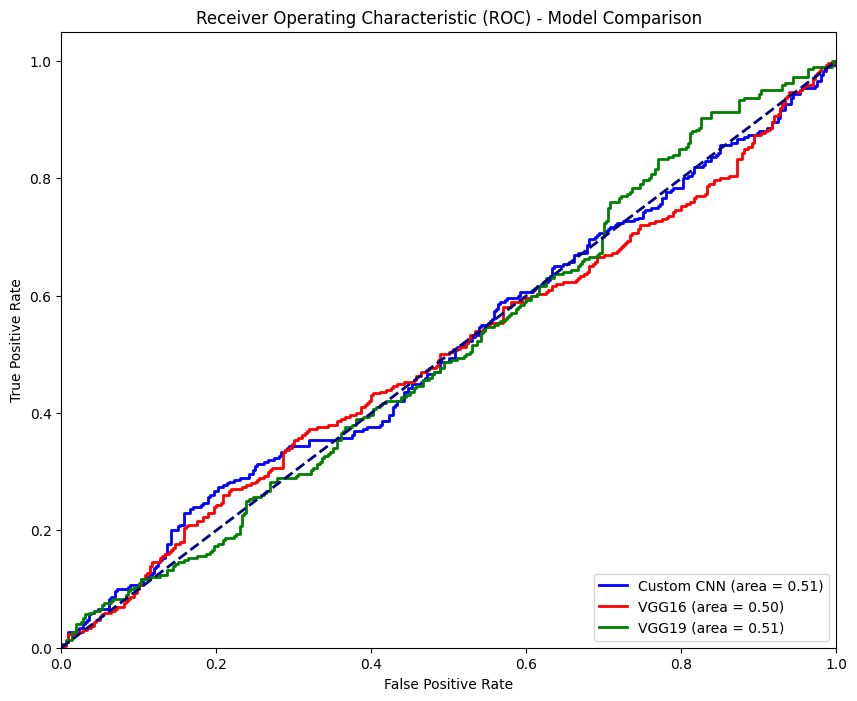

In [25]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Custom CNN (area = {roc_auc:.2f})')

plt.plot(fpr_vgg16, tpr_vgg16, color='red', lw=2, label=f'VGG16 (area = {roc_auc_vgg16:.2f})')

plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label=f'VGG19 (area = {roc_auc_vgg19:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model Comparison')
plt.legend(loc="lower right")
plt.show()